In [8]:
import pandas as pd
import numpy as np
import time
import datetime
from sklearn.metrics import mean_squared_error, r2_score
#from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime,timedelta
#from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

#Leemos el archivo
url = ('total_cases_confirmed_recovered_ec.csv')
df = pd.read_csv(url, sep=';')

FMT = '%d/%m/%Y'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("31/12/2019", FMT)).days)
df= df[df["Ecuador"] > 0.0]
df

,date,Ecuador,Recuperados
61,61,1,0
62,62,6,0
63,63,7,0
65,65,10,0
66,66,13,0
69,69,14,0
70,70,15,0
71,71,17,0
74,74,23,0
75,75,28,0


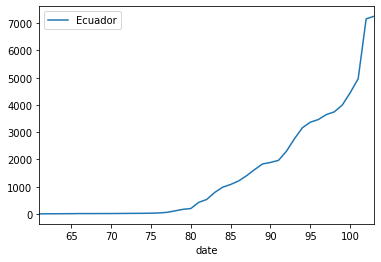

In [9]:
df.plot(x ='date', y='Ecuador')

0.4
0.4


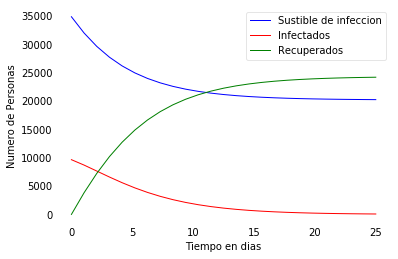

In [10]:
#Ejercicio del GITHUB, confirmados
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.integrate import odeint

def loss(point, data, s0, i0, r0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s0,i0,r0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))
N=44500
#Usamos la prediccion de los datos del modelo polinomial en el dia 105 con un polinomio de grado 5
i0=9650
r0=0
s0=N-i0-r0
data=list(df.iloc [:, 1])
optimal = minimize(loss, [0.001, 0.001], args=(data,s0,i0, r0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])   
beta, gamma = optimal.x
print(beta)
print(gamma)

t = np.linspace(0, 25, 25)
# Las ecuaciones diferenciales del modelo SIR..
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N 
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Vector de condiciones iniciales
y0 = s0,i0,r0
# Integre las ecuaciones SIR en la cuadrícula de tiempo, t. A traves de la funcion odeint()
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T # Obtenicion de resultados


#  Trace los datos en tres curvas separadas para S (t), I (t) y R (t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S, 'b', alpha=1, lw=1, label='Sustible de infeccion')
ax.plot(t, I, 'r', alpha=1, lw=1, label='Infectados')
ax.plot(t, R, 'g', alpha=1, lw=1, label='Recuperados')
ax.set_xlabel('Tiempo en dias')
ax.set_ylabel('Numero de Personas')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [ ]:
#Ejercicio del GITHUB, recuperados
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.integrate import odeint

def loss(point, data, recovered,s0,i0, r0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s0,i0, r0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    # Put more emphasis on recovered people
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2
N=1709600
#Usamos la prediccion de los datos del modelo polinomial en el dia 105 con un polinomio de grado 5
i0=9650
r0=0
s0=100000
recovered=list(df.iloc [:, 2])
data=list(df.iloc [:, 1])
optimal = minimize(loss, [0.001, 0.001], args=(data, recovered,s0,i0,r0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
beta, gamma = optimal.x
print(beta)
print(gamma)
t = np.linspace(0,30,30)
# Las ecuaciones diferenciales del modelo SIR..
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N 
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Vector de condiciones iniciales
y0 = s0,i0,r0
# Integre las ecuaciones SIR en la cuadrícula de tiempo, t. A traves de la funcion odeint()
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T # Obtenicion de resultados


#  Trace los datos en tres curvas separadas para S (t), I (t) y R (t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S, 'b', alpha=1, lw=2, label='Sustible de infeccion')
ax.plot(t, I, 'r', alpha=1, lw=2, label='Infectados')
ax.plot(t, R, 'g', alpha=1, lw=2, label='Recuperados')
ax.set_xlabel('Tiempo en dias')
ax.set_ylabel('Numero de Personas')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

2.399999973648086
2.4


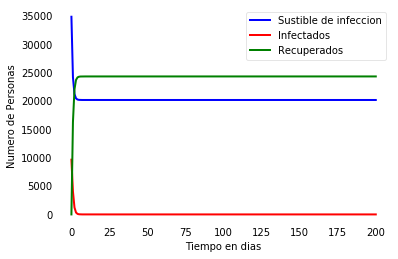

In [11]:

#Ejercicio de pagina, confirmados
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.integrate import odeint

N=44500
#Usamos la prediccion de los datos del modelo polinomial en el dia 105 con un polinomio de grado 5
i0=9650
r0=0
s0=N-i0-r0
data=list(df.iloc [:, 1])

def loss(point, data):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s0,i0,r0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))

optimal = minimize(loss,[0.001, 0.001],args=(data),method='L-BFGS-B',bounds=[(0.00000001, 2.4), (0.00000001, 2.4)])
beta,gamma=optimal.x
print(beta)
print(gamma)

t = np.linspace(0,200,200)
# Las ecuaciones diferenciales del modelo SIR..
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N 
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Vector de condiciones iniciales
y0 = s0,i0,r0
# Integre las ecuaciones SIR en la cuadrícula de tiempo, t. A traves de la funcion odeint()
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T # Obtenicion de resultados


#  Trace los datos en tres curvas separadas para S (t), I (t) y R (t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S, 'b', alpha=1, lw=2, label='Sustible de infeccion')
ax.plot(t, I, 'r', alpha=1, lw=2, label='Infectados')
ax.plot(t, R, 'g', alpha=1, lw=2, label='Recuperados')
ax.set_xlabel('Tiempo en dias')
ax.set_ylabel('Numero de Personas')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [12]:
##Segunda parte
def incidencia(nuevos,riesgo,n):
    return (nuevos/riesgo)*pow(10,n)

def prevalencia(casos,poblacion,n):
    return (casos/poblacion)*pow(10,n)

def relacion(incidencia,tiempo):
    return incidencia*tiempo

incidencia=incidencia(2292,22649,3)
prevalencia = prevalencia(7257,14483499,3)
relacion=relacion(incidencia,28)

print(incidencia)
print(prevalencia)
print(relacion)

101.19652081769614
0.5010529568856256
2833.5025828954917
